In [61]:
import pandas as pd
import numpy as np

from pathlib import Path
from typing import Tuple

import matplotlib.pyplot as plt

In [62]:
def prepare_opencap_data(df: pd.DataFrame) -> pd.DataFrame:
    df.drop(columns=["Frame#" ,"Unnamed: 191"], axis=1, inplace=True)
    df = df.astype(np.float64)

    new_cols = []

    for column in df.columns:
        if not column.startswith("Unnamed"):
            if column == "Time":
                new_cols.append("Time")
            else:
                new_cols.extend(3*[column])

    df.columns = new_cols
    coord = ['X', 'Y', 'Z'] * (len(df.columns)//3)
    coord.insert(0, "t")


    df.columns = pd.MultiIndex.from_tuples(zip(df.columns, coord))

    return df

def prepare_mocap_data(df: pd.DataFrame) -> pd.DataFrame:
    df.reset_index(names="timestamp", inplace=True)
    df["timestamp"] = df["timestamp"].apply(lambda x: x/60)

    # Mocap data is in mm, convert to m
    df["X"] = df["X"] / 1000
    df["Y"] = df["Y"] / 1000
    df["Z"] = df["Z"] / 1000
    return df

def prepare_mocap_force_data(df: pd.DataFrame) -> pd.DataFrame:
    df.reset_index(names="timestamp", inplace=True)
    df.drop(columns=["CoPz", "nan"], inplace=True)
    df["timestamp"] = df["timestamp"].apply(lambda x: x/600)

    return df

## Read data

In [63]:
haedo_data = Path("/Users/xabieririzar/Desktop/Life/Studium/TUM/M.Sc Robotics/Masterarbeit Harvard/Thesis/Subject data/haedo_data")

# Set directories
opencap_data = haedo_data / "opencap_data"
mocap_data = haedo_data / "mocap_data"
opencap_markers = opencap_data / "MarkerData"

# Read force data trial 1
mocap_force_trial_1_right = pd.read_csv(mocap_data / "sit_stand0002_f_20.tsv", delimiter="\t", skiprows=26, names=["FPx", "FPy", "FPz", "Mx", "My", "Mz", "CoPx", "CoPy", "CoPz", "nan"])
mocap_force_trial_1_left = pd.read_csv(mocap_data / "sit_stand0002_f_21.tsv", delimiter="\t", skiprows=26, names=["FPx", "FPy", "FPz", "Mx", "My", "Mz", "CoPx", "CoPy", "CoPz", "nan"])

# Read force data trial 2
mocap_force_trial_2_right = pd.read_csv(mocap_data / "sit_stand0004_f_20.tsv", delimiter="\t", skiprows=26, names=["FPx", "FPy", "FPz", "Mx", "My", "Mz", "CoPx", "CoPy", "CoPz", "nan"])
mocap_force_trial_2_left = pd.read_csv(mocap_data / "sit_stand0004_f_21.tsv", delimiter="\t", skiprows=26, names=["FPx", "FPy", "FPz", "Mx", "My", "Mz", "CoPx", "CoPy", "CoPz", "nan"])

# Read mocap marker data
mocap_marker_trial_1 = pd.read_csv(mocap_data / "sit_stand0002.tsv", delimiter="\t", skiprows=11, names=["X", "Y", "Z"])
mocap_marker_trial_2 = pd.read_csv(mocap_data / "sit_stand0004.tsv", delimiter="\t", skiprows=11, names=["X", "Y", "Z"])

# Read opencap marker data
opencap_marker_trial_1 = pd.read_csv(opencap_markers / "sit_stand_2_w_grf.trc", delimiter="\t", skiprows=3).tail(-1)
opencap_marker_trial_2 = pd.read_csv(opencap_markers / "sit_stand_3_w_grf.trc", delimiter="\t", skiprows=3).tail(-1)

## Process data

In [64]:
# Prepare mocap data
mocap_marker_trial_1 = prepare_mocap_data(mocap_marker_trial_1)
mocap_marker_trial_2 = prepare_mocap_data(mocap_marker_trial_2)

# Prepare opencap data
opencap_marker_trial_1 = prepare_opencap_data(opencap_marker_trial_1)
opencap_marker_trial_2 = prepare_opencap_data(opencap_marker_trial_2)

# Prepare force data
mocap_force_trial_1_right = prepare_mocap_force_data(mocap_force_trial_1_right)
mocap_force_trial_1_left = prepare_mocap_force_data(mocap_force_trial_1_left)
mocap_force_trial_2_right = prepare_mocap_force_data(mocap_force_trial_2_right)
mocap_force_trial_2_left = prepare_mocap_force_data(mocap_force_trial_2_left)

In [65]:
def xcorr_and_shift(x: np.ndarray, y: np.ndarray) -> Tuple[np.ndarray, int]:
    """ Cross-correlate two signals and return the lag

    Args:
        x (np.ndarray): first signal
        y (np.ndarray): second signal

    Returns:
        Tuple[np.ndarray, int]: tuple containing the cross-correlation and the lag
    """
    # Pad the shorter signal with NaN
    size_diff = len(x) - len(y)

    if size_diff > 0:
        y = np.pad(y, (0, size_diff), mode='constant', constant_values=np.nan)
    elif size_diff < 0:
        x = np.pad(x, (0, -size_diff), mode='constant', constant_values=np.nan)

    # Compute cross-correlation and lag
    correlation = np.correlate(x, y, 'full')
    lag = round((np.argmax(correlation) - len(x) + 1)/4)
    print(lag)
    # Shift the 'y' signal based on the calculated lag
    # y_shifted = np.roll(y, -lag)

    return correlation, lag

def sync_mocap_with_opencap(mocap_data: Tuple[pd.DataFrame], opencap_data: pd.DataFrame) -> pd.DataFrame:
    # Cut the mocap data such that it perfectly overlaps with opencap
    marker, force_left, force_right = mocap_data
    _, lag = xcorr_and_shift(marker.X, opencap_data["LKnee"].X)

    force_left = force_left.iloc[-lag*10:-lag*10 + opencap_data.shape[0]*10].reset_index(drop=True)
    force_right = force_right.iloc[-lag*10:-lag*10 + opencap_data.shape[0]*10].reset_index(drop=True)
    marker = marker.iloc[-lag:-lag + opencap_data.shape[0]].reset_index(drop=True)
    
    # Reset time
    force_left["timestamp"] = force_left["timestamp"] - force_left["timestamp"][0]
    force_right["timestamp"] = force_right["timestamp"] - force_right["timestamp"][0]
    marker["timestamp"] = marker["timestamp"] - marker["timestamp"][0]
    
    opencap_data = opencap_data.reset_index(drop=True)

    opencap_data

    return (marker, force_left, force_right), opencap_data

In [66]:
mocap = (mocap_marker_trial_1, mocap_force_trial_1_left, mocap_force_trial_1_right)
mocap, opencap_marker_trial_1 = sync_mocap_with_opencap(mocap_data=mocap, opencap_data=opencap_marker_trial_1)
mocap_marker_trial_1, mocap_force_trial_1_left, mocap_force_trial_1_right = mocap

-111


In [72]:
plt.plot(mocap_marker_trial_1.timestamp, mocap_marker_trial_1.X, label="mocap")
plt.plot(mocap_force_trial_1_left.timestamp, mocap_force_trial_1_left.FPx, label="mocap force")
plt.plot(mocap_force_trial_1_right.timestamp, mocap_force_trial_1_right.FPx, label="mocap force")
plt.plot(opencap_marker_trial_1.Time.t, opencap_marker_trial_1["LKnee"].X, label="opencap")
plt.legend()

AttributeError: 'Series' object has no attribute 'normalize'

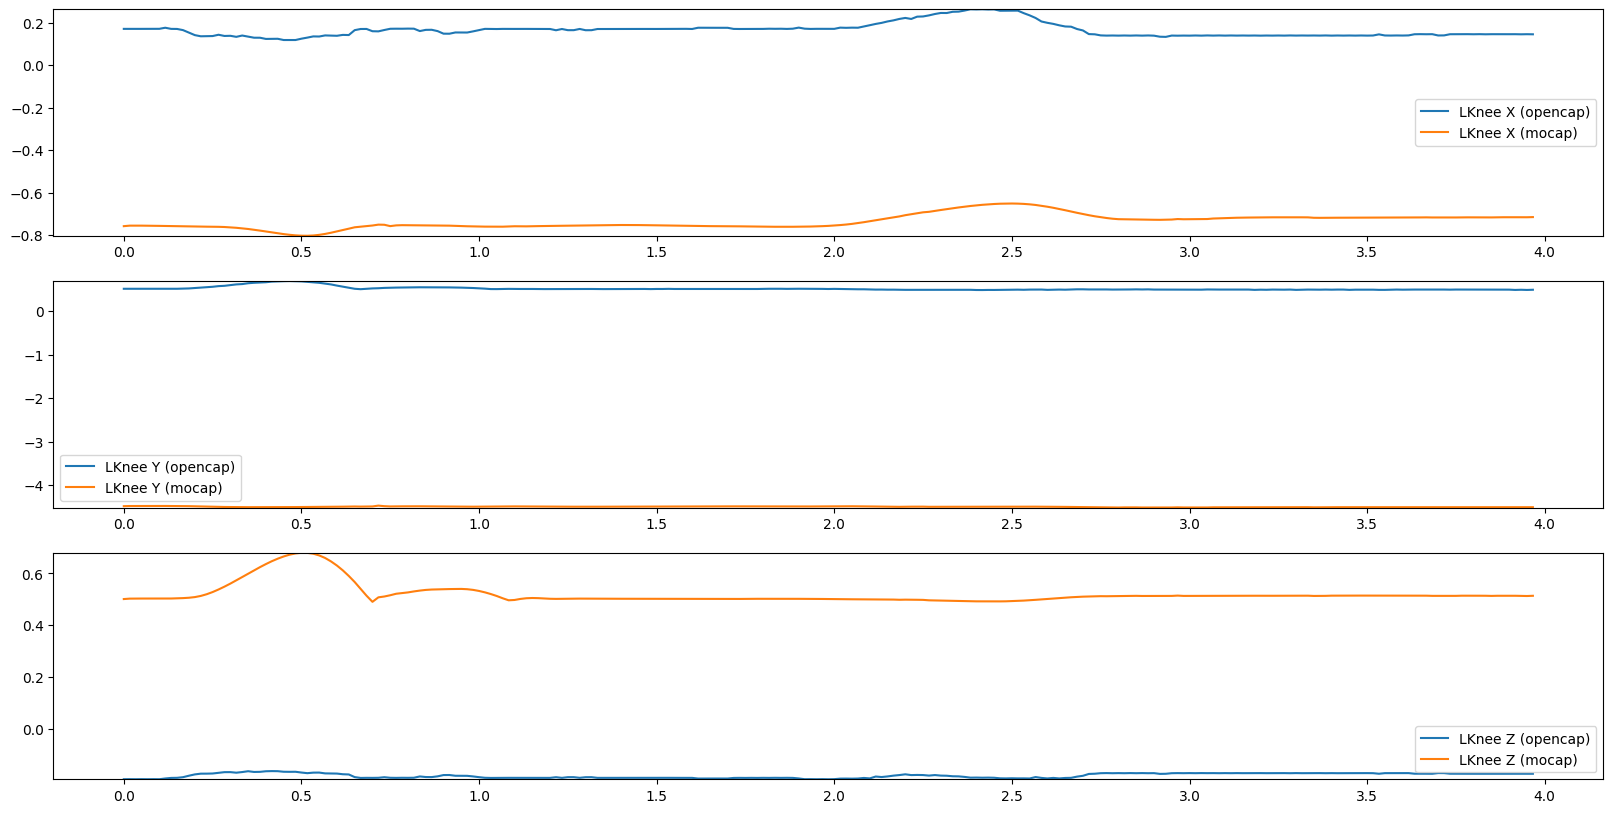

In [69]:
fig, axs = plt.subplots(3, sharex="row", figsize=(20, 10))

# Plot X data
axs[0].plot(opencap_marker_trial_1["Time"].t, opencap_marker_trial_1["LKnee"].X, label="LKnee X (opencap)")
axs[0].plot(mocap_marker_trial_1.timestamp, mocap_marker_trial_1.X, label="LKnee X (mocap)")
#axs[0].plot(mocap_force_trial_1_right.timestamp, mocap_force_trial_1_right.FPx, label="LKnee X (mocap force)")
axs[0].legend()

# Plot Y data
axs[1].plot(opencap_marker_trial_1["Time"].t, opencap_marker_trial_1["LKnee"].Y, label="LKnee Y (opencap)")
axs[1].plot(mocap_marker_trial_1.timestamp, mocap_marker_trial_1.Y, label="LKnee Y (mocap)")
#axs[1].plot(mocap_force_trial_1_right.timestamp, mocap_force_trial_1_right.FPy, label="LKnee Y (mocap force)")
axs[1].legend()

# Plot Z data
axs[2].plot(opencap_marker_trial_1["Time"].t, opencap_marker_trial_1["LKnee"].Z, label="LKnee Z (opencap)")
axs[2].plot(mocap_marker_trial_1.timestamp, mocap_marker_trial_1.Z, label="LKnee Z (mocap)")
#axs[2].plot(mocap_force_trial_1_right.timestamp, mocap_force_trial_1_right.FPz, label="LKnee Z (mocap force)")
axs[2].legend()

axs[0].autoscale(axis='y', tight=True)
axs[1].autoscale(axis='y', tight=True)
axs[2].autoscale(axis='y', tight=True)

# Display the plot
plt.show()